In [52]:
import pandas as pd
import numpy as np
import pylab as pl
import scipy.io as sio
import seaborn as sns
import statsmodels.api as sm
import funcs as func
import matplotlib.pyplot as plt
import sys
import pdb
import glob
import pickle

import sys
sys.path.append('/home/jyotika/Utils/hddm/')

import hddm

data_dir = "./Data/Y_maze/Decision_times/"
data_target_dir = "./Data/processed_data/Y_maze/for_b_cpp_calculation/"
figure_dir = "./Figures/Y_maze/"

plt.rcParams["figure.facecolor"] = "w"

In [53]:
all_conflicts = pd.read_csv(data_target_dir+"for_av_fits_hddm.csv")
conf_dict = {1.0:"No",0.9:"Low",0.75:"High"}


In [54]:
all_conflicts.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'r_t0', 'r_t1', 'cp', 'epoch_number',
       'reward_p_t0', 'session', 'conflict', 'volatility', 'condition',
       'p_id_solution', 'action_history', 'chosen_action', 'trial_num', 'rt',
       'rewarded', 'optimal', 'cpp', 'ideal_B', 'b_t0', 'b_t1', 'MC'],
      dtype='object')

In [59]:
conflict_type = "Low"
volatility_type = "Low"

n_samples, n_burn, n_thin = 6000, 500, 0

# n_samples, n_burn, n_thin = 10, 5, 0 # min. samples to test the workflow

n_effective_samples = n_samples - n_burn
model_specifications = [('a~cpp_shifted', 'v~ideal_B_shifted'),
                        ('v~cpp_shifted', 'a~ideal_B_shifted'),
                        ('a~cpp_shifted'),
                        ('v~cpp_shifted'),
                        ('a~ideal_B_shifted'),
                        ('v~ideal_B_shifted'),
          ('a~1', 'v~1')]
model_names = ['a_cpp_v_B', 'v_cpp_a_B', 'a_cpp', 'v_cpp',
               'a_B', 'v_B', 'intercept']

# Check with lesser model examples
# model_specifications = [('a~cpp_shifted', 'v~ideal_B_shifted'),
#                         ('v~ideal_B_shifted')]
#          # ('a~1', 'v~1')]

# model_names = ['a_cpp_v_B', 'v_B']



In [60]:
def estimate_regression_model(model_specification, model_name, subject, data, model_objects,
                              n_samples=n_samples, n_burn=n_burn, accuracy_coding=True, convergence_iteration=None):

    if accuracy_coding:
        reg_model = hddm.HDDMRegressor(data=data, models=model_specification, bias=False, group_only_regressors=True, p_outlier=0.05) # accuracy coded
        reg_model.find_starting_values()
        reg_model.sample(n_samples, burn=n_burn, dbname=model_name, db='pickle')
        print("dic",reg_model.dic)
    else:
        reg_model = hddm.HDDMRegressor(data=data, models=model_specification, bias=True, group_only_regressors=True, p_outlier=0.05) # stim coded
        reg_model.find_starting_values()
        reg_model.sample(n_samples, burn=n_burn, dbname=model_name, db='pickle')

    if convergence_iteration is None:
        model_objects[model_name + '_' + str(subject)] = reg_model
    else:
        model_objects[model_name + '_' + str(subject) + '_iter' + str(convergence_iteration)] = reg_model

In [61]:
def generate_trialwise_estimates(learning_sig_df, av_beta_intercept_df,model):
    n = len(learning_sig_df)
    
    intercepts = []
    slopes = []
    cpp = learning_sig_df.cpp; ideal_B = learning_sig_df.ideal_B    
    
    comps = model.split('_')
    if len(comps) == 1 and comps[0]=='intercept':
        print("do something")
    else:
        for i in np.arange(0,len(comps),2):
            indep_var = comps[i]
            dep_var = comps[i+1]

            if indep_var == "v":
                mean_intercept = av_beta_intercept_df.v_Intercept.mean()
                jittered_intercept = av_beta_intercept_df.v_Intercept.sample(n).reset_index(drop=True)

                if dep_var == "B":
                    B_mean_beta = av_beta_intercept_df.v_ideal_B_shifted.mean()
                    B_jittered_beta = av_beta_intercept_df.v_ideal_B_shifted.sample(n).reset_index(drop=True)
                    v_trialwise_estimate = mean_intercept + B_mean_beta * ideal_B
                    v_trialwise_estimate_jittered = jittered_intercept + B_jittered_beta * ideal_B
               
                elif dep_var == "cpp":
                    cpp_mean_beta = av_beta_intercept_df.v_cpp_shifted.mean()
                    cpp_jittered_beta = av_beta_intercept_df.v_cpp_shifted.sample(n).reset_index(drop=True)
                    v_trialwise_estimate = mean_intercept + cpp_mean_beta * cpp
                    v_trialwise_estimate_jittered = jittered_intercept + cpp_jittered_beta * cpp
             
                learning_sig_df['v_est'] = v_trialwise_estimate
                learning_sig_df['v_est_jittered'] = v_trialwise_estimate_jittered
            
            elif indep_var == "a":
                mean_intercept = av_beta_intercept_df.a_Intercept.mean()
                jittered_intercept = av_beta_intercept_df.a_Intercept.sample(n).reset_index(drop=True)
   
                if dep_var == "B":
                    B_mean_beta = av_beta_intercept_df.a_ideal_B_shifted.mean()
                    B_jittered_beta = av_beta_intercept_df.a_ideal_B_shifted.sample(n).reset_index(drop=True)
                    a_trialwise_estimate = mean_intercept + B_mean_beta * ideal_B
                    a_trialwise_estimate_jittered = jittered_intercept + B_jittered_beta * ideal_B
               
                elif dep_var == "cpp":
                    cpp_mean_beta = av_beta_intercept_df.a_cpp_shifted.mean()
                    cpp_jittered_beta = av_beta_intercept_df.a_cpp_shifted.sample(n).reset_index(drop=True)
                    a_trialwise_estimate = mean_intercept + cpp_mean_beta * cpp
                    a_trialwise_estimate_jittered = jittered_intercept + cpp_jittered_beta * cpp
                
                learning_sig_df['a_est'] = a_trialwise_estimate
                learning_sig_df['a_est_jittered'] = a_trialwise_estimate_jittered
         
   
    return learning_sig_df


In [ ]:
all_b_cpp_hddm_fits = pd.DataFrame()

# Run a different set of model exploration for every conflict - volatility condition

for grp in all_conflicts.groupby(["conflict","volatility"]):


    # data = data.loc[(data["conflict"] == conflict_type)&(data["volatility"]==volatility_type)]
    data = grp[1].copy()
    data["p_optimal"] = [ 1.0 if x == "No" else 0.9 if x == "Low" else 0.75  for x in data["conflict"] ]
    data = data.rename(columns={"optimal":"block"})
    data["p_accuracy"] = (data["chosen_action"]==data["block"]).astype(int)

    hddm_df = pd.DataFrame()


    # In[24]:
    hddm_df['response'] = data.p_accuracy
    hddm_df['rt'] = data.rt/1000.
    hddm_df['cpp'] = data.cpp
    hddm_df['ideal_B'] = data.ideal_B
    hddm_df['reward_code'] = data.p_optimal
    #hddm_df['lambda_val'] = data.lambda_val
    hddm_df['p_optimal'] = data.p_optimal
    #hddm_df['shifted_epoch_trial'] = data.shifted_epoch_trial
    hddm_df['cpp_shifted'] = hddm_df.cpp.shift(1)
    hddm_df['ideal_B_shifted'] = hddm_df.ideal_B.shift(1)


    hddm_df.dropna(inplace=True) # need to drop nas for HDDMRegressor

    data = hddm.utils.flip_errors(hddm_df)

    fig = plt.figure()
    ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
    data.rt.hist(bins=20, histtype='step', ax=ax)
    plt.savefig(figure_dir+'rt_error_dists_'+conflict_type+'_'+volatility_type+'.pdf')
    
    n_samples, n_burn, n_thin = len(grp[1])+500, 500, 0

    model_inputs = dict(zip(model_names, model_specifications))
    model_objects = dict()
    print(model_inputs)

    for model_name, model_specification in model_inputs.items():
        estimate_regression_model(model_specification, model_name,1, data, model_objects,n_samples,n_burn)
        print('model sampling complete')

    locals().update(model_objects) # convert keys and values to variables
    model_objects    

    all_models = [model_objects[k] for k in model_objects.keys()]
    all_models
    model_dict = dict(zip(model_names, all_models))


    subj_df_list=[]
    for model in model_dict:
        subj_df = model_dict[model].get_traces()
        subj_df['subj_idx'] = [1] * n_effective_samples # subject id is 1
        subj_df['model'] = model
        subj_df['dic'] = model_dict[model].dic
        subj_df_list.append(subj_df)
    subj_df_all = pd.concat(subj_df_list, sort=True)
    subj_df_all

    dics_df = (subj_df_all.groupby(['subj_idx', 'model'])['dic'].unique() - subj_df_all.loc[subj_df_all.model == 'intercept'].groupby(['subj_idx'])['dic'].unique()).reset_index()
    dics_df['raw_dic'] = subj_df_all.groupby(['subj_idx', 'model'])['dic'].unique().reset_index()['dic']
    dics_df = dics_df.rename(index=str, columns={"dic": "null_adj_dic"})
    dics_df['null_adj_dic'] = dics_df['null_adj_dic'].str[0]
    dics_df['raw_dic'] = dics_df['raw_dic'].str[0]

    subj_df_all.to_csv(data_target_dir+'subjectwise_ddm_reg_full_fits_acc_'+conflict_type+"_"+volatility_type+'.csv')
    dics_df.to_csv(data_target_dir+'subjectwise_dics_reg_full_fits_acc_'+conflict_type+'_'+volatility_type+'.csv')

    pl.figure()
    g1 = sns.barplot(x='model', y='null_adj_dic', data=dics_df)
    g1.figure.savefig(figure_dir+"DIC_comparison_models_"+conflict_type+"_"+volatility_type+".png")

    subj_df_all_best_model = subj_df_all.loc[subj_df_all["dic"]==np.min(subj_df_all["dic"])]

    pickle.dump(subj_df_all_best_model,open("best_model_"+conflict_type+"_"+volatility_type+".pickle","wb"))

    data = generate_trialwise_estimates(data, subj_df_all_best_model,subj_df_all_best_model.iloc[0]["model"])
    data["conflict"] = grp[0][0]
    data["volatility"] = grp[0][1]
    all_b_cpp_hddm_fits = all_b_cpp_hddm_fits.append(data)
    

{'a_cpp_v_B': ('a~cpp_shifted', 'v~ideal_B_shifted'), 'v_cpp_a_B': ('v~cpp_shifted', 'a~ideal_B_shifted'), 'a_cpp': 'a~cpp_shifted', 'v_cpp': 'v~cpp_shifted', 'a_B': 'a~ideal_B_shifted', 'v_B': 'v~ideal_B_shifted', 'intercept': ('a~1', 'v~1')}
No model attribute --> setting up standard HDDM
Set model to ddm
Reg Model:
{'outcome': 'a', 'model': 'cpp_shifted', 'params': ['a_Intercept', 'a_cpp_shifted'], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7fd71908b4c0>}
Uses Identity Link
Reg Model:
{'outcome': 'v', 'model': 'ideal_B_shifted', 'params': ['v_Intercept', 'v_ideal_B_shifted'], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7fd71908b1f0>}
Uses Identity Link
-6083.041632872333
-6082.895443376311
 [-----------------100%-----------------] 6056 of 6056 complete in 883.0 secdic 12153.620293627053
model sampling complete
No model attribute --> setting up standard HDDM
Set model to ddm
Reg Model:
{'outcome': 'v', 'model': 'cpp_shifted', 'params

In [ ]:
subj_df_all_best_model

In [ ]:
dics_df

In [ ]:
sns.lmplot(x="ideal_B_shifted",y="v_est_jittered",data=data)

In [ ]:
all_b_cpp_hddm_fits

In [34]:
data

,response,rt,cpp,ideal_B,reward_code,p_optimal,cpp_shifted,ideal_B_shifted,v_est,v_est_jittered
931,0,-0.656,0.006562,0.003780,0.9,0.9,0.007560,0.000000,0.367024,0.366859
932,0,-0.730,0.006195,0.007036,0.9,0.9,0.006562,0.003780,0.367037,0.348648
933,1,0.732,0.006103,0.010091,0.9,0.9,0.006195,0.007036,0.367049,0.345318
934,1,0.573,1.000000,0.004921,0.9,0.9,0.006103,0.010091,0.367028,0.366490
935,0,-1.207,1.000000,0.497887,0.9,0.9,1.000000,0.004921,0.368993,0.392982
...,...,...,...,...,...,...,...,...,...,...
36547,1,1.801,0.005762,0.483973,0.9,0.9,0.005363,0.483586,0.368938,NaN
36548,1,0.678,0.005278,0.487029,0.9,0.9,0.005762,0.483973,0.368950,NaN
36549,1,2.265,1.000000,0.487348,0.9,0.9,0.005278,0.487029,0.368951,NaN
36550,1,4.646,1.000000,-0.500000,0.9,0.9,1.000000,0.487348,0.365015,NaN


{'a_cpp_v_B': ('a~cpp_shifted', 'v~ideal_B_shifted'), 'v_cpp_a_B': ('v~cpp_shifted', 'a~ideal_B_shifted'), 'a_cpp': 'a~cpp_shifted', 'v_cpp': 'v~cpp_shifted', 'a_B': 'a~ideal_B_shifted', 'v_B': 'v~ideal_B_shifted', 'intercept': ('a~1', 'v~1')}


No model attribute --> setting up standard HDDM
Set model to ddm
Reg Model:
{'outcome': 'a', 'model': 'cpp_shifted', 'params': ['a_Intercept', 'a_cpp_shifted'], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7fbb4eae5160>}
Uses Identity Link
Reg Model:
{'outcome': 'v', 'model': 'ideal_B_shifted', 'params': ['v_Intercept', 'v_ideal_B_shifted'], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7fbb4f0daa60>}
Uses Identity Link
-11356.365841260704
-11356.357139698135
 [-----------------100%-----------------] 10001 of 10000 complete in 1898.3 secmodel sampling complete
No model attribute --> setting up standard HDDM
Set model to ddm
Reg Model:
{'outcome': 'v', 'model': 'cpp_shifted', 'params': ['v_Intercept', 'v_cpp_shifted'], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7fbb4ea891f0>}
Uses Identity Link
Reg Model:
{'outcome': 'a', 'model': 'ideal_B_shifted', 'params': ['a_Intercept', 'a_ideal_B_shifted'], 'link_func': <func

In [28]:
model_objects

{'a_cpp_v_B_1': <hddm.models.hddm_regression.HDDMRegressor at 0x7fbb4ed59ac0>,
 'v_cpp_a_B_1': <hddm.models.hddm_regression.HDDMRegressor at 0x7fbb4f2f1df0>,
 'a_cpp_1': <hddm.models.hddm_regression.HDDMRegressor at 0x7fbb4e9e5e50>,
 'v_cpp_1': <hddm.models.hddm_regression.HDDMRegressor at 0x7fbb4edc9880>,
 'a_B_1': <hddm.models.hddm_regression.HDDMRegressor at 0x7fbb4eaf0d00>,
 'v_B_1': <hddm.models.hddm_regression.HDDMRegressor at 0x7fbb4f2b5cd0>,
 'intercept_1': <hddm.models.hddm_regression.HDDMRegressor at 0x7fbb4ebde5e0>}

In [29]:
from kabuki.analyze import check_geweke
for k in model_objects.keys():
    print(k)
    print(check_geweke(model_objects[k]))

a_cpp_v_B_1


AssertionError: Chain of knode_name                t
stochastic             True
observed              False
subj                  False
node                      t
tag                      ()
depends                  []
hidden                False
response                NaN
rt                      NaN
cpp                     NaN
ideal_B                 NaN
reward_code             NaN
p_optimal               NaN
cpp_shifted             NaN
ideal_B_shifted         NaN
mean               0.067499
std                0.003103
2.5q               0.061335
25q                0.065396
50q                0.067485
75q                0.069603
97.5q              0.073491
mc err             0.000047
Name: t, dtype: object not properly converged

{'a_cpp_v_B_1': <hddm.models.hddm_regression.HDDMRegressor at 0x7fbb4ed59ac0>,
 'v_cpp_a_B_1': <hddm.models.hddm_regression.HDDMRegressor at 0x7fbb4f2f1df0>,
 'a_cpp_1': <hddm.models.hddm_regression.HDDMRegressor at 0x7fbb4e9e5e50>,
 'v_cpp_1': <hddm.models.hddm_regression.HDDMRegressor at 0x7fbb4edc9880>,
 'a_B_1': <hddm.models.hddm_regression.HDDMRegressor at 0x7fbb4eaf0d00>,
 'v_B_1': <hddm.models.hddm_regression.HDDMRegressor at 0x7fbb4f2b5cd0>,
 'intercept_1': <hddm.models.hddm_regression.HDDMRegressor at 0x7fbb4ebde5e0>}

In [33]:
model_dict

{'a_cpp_v_B': <hddm.models.hddm_regression.HDDMRegressor at 0x7fbb4ed59ac0>,
 'v_cpp_a_B': <hddm.models.hddm_regression.HDDMRegressor at 0x7fbb4f2f1df0>,
 'a_cpp': <hddm.models.hddm_regression.HDDMRegressor at 0x7fbb4e9e5e50>,
 'v_cpp': <hddm.models.hddm_regression.HDDMRegressor at 0x7fbb4edc9880>,
 'a_B': <hddm.models.hddm_regression.HDDMRegressor at 0x7fbb4eaf0d00>,
 'v_B': <hddm.models.hddm_regression.HDDMRegressor at 0x7fbb4f2b5cd0>,
 'intercept': <hddm.models.hddm_regression.HDDMRegressor at 0x7fbb4ebde5e0>}

,a,a_Intercept,a_cpp_shifted,a_ideal_B_shifted,dic,model,subj_idx,t,v,v_Intercept,v_cpp_shifted,v_ideal_B_shifted
0,NaN,1.843262,0.022471,NaN,22699.256534,a_cpp_v_B,1,0.068784,NaN,0.308790,NaN,0.077368
1,NaN,1.843734,0.005239,NaN,22699.256534,a_cpp_v_B,1,0.066217,NaN,0.294203,NaN,0.057790
2,NaN,1.823620,0.014141,NaN,22699.256534,a_cpp_v_B,1,0.066899,NaN,0.292775,NaN,0.060039
3,NaN,1.829472,0.021029,NaN,22699.256534,a_cpp_v_B,1,0.069020,NaN,0.305111,NaN,0.057700
4,NaN,1.821119,0.019395,NaN,22699.256534,a_cpp_v_B,1,0.070478,NaN,0.280333,NaN,0.092395
...,...,...,...,...,...,...,...,...,...,...,...,...
8995,NaN,1.845762,NaN,NaN,22698.195863,intercept,1,0.068458,NaN,0.331640,NaN,NaN
8996,NaN,1.832618,NaN,NaN,22698.195863,intercept,1,0.071595,NaN,0.306333,NaN,NaN
8997,NaN,1.811925,NaN,NaN,22698.195863,intercept,1,0.073052,NaN,0.323404,NaN,NaN
8998,NaN,1.831518,NaN,NaN,22698.195863,intercept,1,0.061773,NaN,0.318548,NaN,NaN


In [39]:
dics_df

,subj_idx,model,dic
0,1,a_B,[1.9513635509101732]
1,1,a_cpp,[-0.6082596179294342]
2,1,a_cpp_v_B,[1.0606708499362867]
3,1,intercept,[0.0]
4,1,v_B,[1.7126305301680986]
5,1,v_cpp,[-30.56421813439374]
6,1,v_cpp_a_B,[-28.44714339300117]


In [41]:
dics_df

,subj_idx,model,null_adj_dic,raw_dic
0,1,a_B,1.951364,22700.147227
1,1,a_cpp,-0.608260,22697.587604
2,1,a_cpp_v_B,1.060671,22699.256534
3,1,intercept,0.000000,22698.195863
4,1,v_B,1.712631,22699.908494
5,1,v_cpp,-30.564218,22667.631645
6,1,v_cpp_a_B,-28.447143,22669.748720


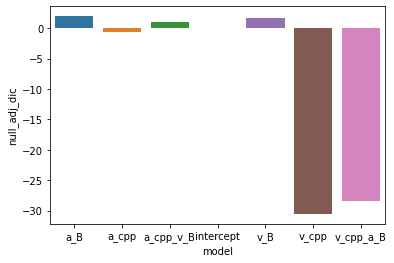

In [47]:
subj_df_all_best_model

,a,a_Intercept,a_cpp_shifted,a_ideal_B_shifted,dic,model,subj_idx,t,v,v_Intercept,v_cpp_shifted,v_ideal_B_shifted
0,1.830240,NaN,NaN,NaN,22667.631645,v_cpp,1,0.070096,NaN,0.364855,-0.130244,NaN
1,1.835451,NaN,NaN,NaN,22667.631645,v_cpp,1,0.068545,NaN,0.364342,-0.154027,NaN
2,1.838213,NaN,NaN,NaN,22667.631645,v_cpp,1,0.071442,NaN,0.389669,-0.141510,NaN
3,1.824754,NaN,NaN,NaN,22667.631645,v_cpp,1,0.068317,NaN,0.390406,-0.172658,NaN
4,1.827411,NaN,NaN,NaN,22667.631645,v_cpp,1,0.070341,NaN,0.377073,-0.099485,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
8995,1.850990,NaN,NaN,NaN,22667.631645,v_cpp,1,0.064784,NaN,0.353859,-0.117529,NaN
8996,1.844899,NaN,NaN,NaN,22667.631645,v_cpp,1,0.067684,NaN,0.375704,-0.145016,NaN
8997,1.842091,NaN,NaN,NaN,22667.631645,v_cpp,1,0.068654,NaN,0.377814,-0.141705,NaN
8998,1.828570,NaN,NaN,NaN,22667.631645,v_cpp,1,0.065453,NaN,0.379786,-0.150560,NaN


In [57]:
model_dict['v_cpp'].plot_posterior_predictive()

<Figure size 576x432 with 0 Axes>